In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


Imports 

In [2]:
!pip install numpy>=1.20.0
!pip install  pandas>=1.3.0
!pip install matplotlib>=3.4.0
!pip install seaborn>=0.11.0
!pip install scikit-learn>=1.0.0
!pip install imbalanced-learn>=0.8.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')


In [5]:
print(f"Dataset Shape: {df.shape}")
print("\nDataset Information:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

Dataset Shape: (284807, 31)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20

In [6]:
print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [7]:
fraud_count = df['Class'].value_counts()
print("\nClass Distribution:")
print(fraud_count)
print(f"Percentage of fraudulent transactions: {fraud_count[1]/len(df)*100:.4f}%")


Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64
Percentage of fraudulent transactions: 0.1727%


In [9]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (Highly Imbalanced)')
plt.savefig('class_distribution.png')
plt.close()

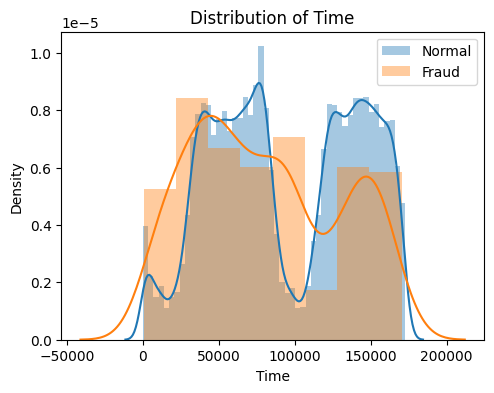

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.distplot(df[df['Class'] == 0]['Time'], label='Normal')
sns.distplot(df[df['Class'] == 1]['Time'], label='Fraud')
plt.title('Distribution of Time')
plt.legend()

In [11]:
plt.subplot(1, 2, 2)
sns.distplot(df[df['Class'] == 0]['Amount'], label='Normal')
sns.distplot(df[df['Class'] == 1]['Amount'], label='Fraud')
plt.title('Distribution of Amount')
plt.legend()
plt.savefig('time_amount_distribution.png')
plt.close()


In [12]:
# Statistical comparison between normal and fraud transactions
print("\nNormal Transactions - Amount Statistics:")
print(df[df['Class'] == 0]['Amount'].describe())
print("\nFraudulent Transactions - Amount Statistics:")
print(df[df['Class'] == 1]['Amount'].describe())




Normal Transactions - Amount Statistics:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Fraudulent Transactions - Amount Statistics:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


In [13]:
# Correlation matrix
plt.figure(figsize=(16, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.close()

In [14]:
# Feature distributions: comparison between normal and fraudulent transactions
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V10', 'V11', 'V12', 'V14', 'V17']
plt.figure(figsize=(20, 40))
for i, feature in enumerate(features):
    plt.subplot(5, 2, i+1)
    sns.distplot(df[df['Class'] == 0][feature], label='Normal')
    sns.distplot(df[df['Class'] == 1][feature], label='Fraud')
    plt.title(f'Distribution of {feature}')
    plt.legend()
plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.close()

# Data Preprocessing

In [15]:
X = df.drop(['Class', 'Time'], axis=1)  # Drop original Time feature
y = df['Class']

In [16]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Class distribution in training set: {Counter(y_train)}")
print(f"Class distribution in testing set: {Counter(y_test)}")

Training set shape: (227845, 29)
Testing set shape: (56962, 29)
Class distribution in training set: Counter({0: 227451, 1: 394})
Class distribution in testing set: Counter({0: 56864, 1: 98})


In [19]:
def plot_class_distribution(y, title):
    plt.figure(figsize=(8, 6))
    counter = Counter(y)
    sns.barplot(x=list(counter.keys()), y=list(counter.values()))
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    return plt

In [20]:
plot_class_distribution(y_train, 'Original Class Distribution in Training Set')
plt.savefig('original_distribution.png')
plt.close()


In [21]:
# Strategy 1: SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(sampling_strategy=0.1, random_state=42)  # Increase minority class to 10% of majority
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"After SMOTE - Training set shape: {X_train_smote.shape}")
print(f"After SMOTE - Class distribution: {Counter(y_train_smote)}")

After SMOTE - Training set shape: (250196, 29)
After SMOTE - Class distribution: Counter({0: 227451, 1: 22745})


In [22]:
plot_class_distribution(y_train_smote, 'Class Distribution After SMOTE')
plt.savefig('smote_distribution.png')
plt.close()


In [23]:
# Strategy 2: Combined SMOTE and Undersampling
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Reduce majority class after SMOTE
X_train_combined, y_train_combined = rus.fit_resample(X_train_smote, y_train_smote)

print(f"After Combined SMOTE+Undersampling - Training set shape: {X_train_combined.shape}")
print(f"After Combined SMOTE+Undersampling - Class distribution: {Counter(y_train_combined)}")

After Combined SMOTE+Undersampling - Training set shape: (68235, 29)
After Combined SMOTE+Undersampling - Class distribution: Counter({0: 45490, 1: 22745})


In [24]:
plot_class_distribution(y_train_combined, 'Class Distribution After SMOTE + Undersampling')
plt.savefig('combined_distribution.png')
plt.close()

# model building

In [25]:
# Function to train and evaluate models
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Training time
    training_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"\n--- {model_name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'training_time': training_time,
        'confusion_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve
    }



# Model 1: Logistic Regression with original imbalanced dat

In [26]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg_results = train_evaluate_model(log_reg, X_train, y_train, X_test, y_test, "Logistic Regression (Imbalanced)")



--- Logistic Regression (Imbalanced) Results ---
Accuracy: 0.9745
Precision: 0.0586
Recall: 0.9184
F1 Score: 0.1101
ROC AUC: 0.9713
PR AUC: 0.7634
Training Time: 1.04 seconds
Confusion Matrix:
[[55417  1447]
 [    8    90]]


# Model 2: Logistic Regression with SMOTE

In [27]:
log_reg_smote = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg_smote_results = train_evaluate_model(log_reg_smote, X_train_smote, y_train_smote, X_test, y_test, "Logistic Regression (SMOTE)")


--- Logistic Regression (SMOTE) Results ---
Accuracy: 0.9730
Precision: 0.0556
Recall: 0.9184
F1 Score: 0.1049
ROC AUC: 0.9697
PR AUC: 0.7683
Training Time: 1.05 seconds
Confusion Matrix:
[[55336  1528]
 [    8    90]]


# Model 3: Logistic Regression with combined approach

In [28]:
log_reg_combined = LogisticRegression(max_iter=1000, random_state=42)  # No need for class_weight with balanced data
log_reg_combined_results = train_evaluate_model(log_reg_combined, X_train_combined, y_train_combined, X_test, y_test, "Logistic Regression (Combined)")



--- Logistic Regression (Combined) Results ---
Accuracy: 0.9859
Precision: 0.1009
Recall: 0.9082
F1 Score: 0.1816
ROC AUC: 0.9691
PR AUC: 0.7626
Training Time: 0.51 seconds
Confusion Matrix:
[[56071   793]
 [    9    89]]


# Model 4: Random Forest with SMOTE

In [29]:
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote_results = train_evaluate_model(rf_smote, X_train_smote, y_train_smote, X_test, y_test, "Random Forest (SMOTE)")


--- Random Forest (SMOTE) Results ---
Accuracy: 0.9995
Precision: 0.8660
Recall: 0.8571
F1 Score: 0.8615
ROC AUC: 0.9686
PR AUC: 0.8783
Training Time: 213.29 seconds
Confusion Matrix:
[[56851    13]
 [   14    84]]


# Model 5: Gradient Boosting with SMOTE

In [30]:
gb_smote = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_smote_results = train_evaluate_model(gb_smote, X_train_smote, y_train_smote, X_test, y_test, "Gradient Boosting (SMOTE)")


--- Gradient Boosting (SMOTE) Results ---
Accuracy: 0.9984
Precision: 0.5152
Recall: 0.8673
F1 Score: 0.6464
ROC AUC: 0.9794
PR AUC: 0.7693
Training Time: 377.29 seconds
Confusion Matrix:
[[56784    80]
 [   13    85]]


# Hyperparameter tuning for Random Forest (which performed better)

In [31]:
print("\nPerforming Hyperparameter Tuning for Random Forest...")
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_tuned = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='average_precision',  # Using PR AUC for imbalanced data
    cv=3,
    verbose=1,
    n_jobs=-1
)

rf_tuned.fit(X_train_smote, y_train_smote)
print(f"Best Parameters: {rf_tuned.best_params_}")

# Train and evaluate the tuned model
rf_tuned_results = train_evaluate_model(rf_tuned.best_estimator_, X_train_smote, y_train_smote, X_test, y_test, "Tuned Random Forest (SMOTE)")



Performing Hyperparameter Tuning for Random Forest...
Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

## 7. Model Evaluation

In [33]:
# Collect all results
all_results = [
    log_reg_results,
    log_reg_smote_results,
    log_reg_combined_results,
    rf_smote_results,
    gb_smote_results,
  
]

model_names = [
    "LR (Imbalanced)",
    "LR (SMOTE)",
    "LR (Combined)",
    "RF (SMOTE)",
    "GB (SMOTE)",
    
]

In [34]:
# Create comparison tables
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']
comparison_data = []

for i, result in enumerate(all_results):
    row = [model_names[i]]
    for metric in metrics:
        row.append(result[metric])
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data, columns=['Model'] + metrics)
print("\nModel Comparison:")
print(comparison_df)


Model Comparison:
             Model  accuracy  precision    recall        f1   roc_auc  \
0  LR (Imbalanced)  0.974457   0.058556  0.918367  0.110092  0.971325   
1       LR (SMOTE)  0.973035   0.055624  0.918367  0.104895  0.969673   
2    LR (Combined)  0.985920   0.100907  0.908163  0.181633  0.969104   
3       RF (SMOTE)  0.999526   0.865979  0.857143  0.861538  0.968623   
4       GB (SMOTE)  0.998367   0.515152  0.867347  0.646388  0.979413   

     pr_auc  
0  0.763412  
1  0.768346  
2  0.762621  
3  0.878283  
4  0.769311  


In [35]:
# Find the best model based on PR AUC (most appropriate for imbalanced data)
best_model_idx = comparison_df['pr_auc'].idxmax()
best_model_name = comparison_df.iloc[best_model_idx]['Model']
best_model = all_results[best_model_idx]['model']
print(f"\nBest model based on PR AUC: {best_model_name}")


Best model based on PR AUC: RF (SMOTE)


In [36]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for i, result in enumerate(all_results):
    plt.plot(result['fpr'], result['tpr'], label=f"{model_names[i]} (AUC = {result['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.savefig('roc_curves.png')
plt.close()

In [37]:
# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
for i, result in enumerate(all_results):
    plt.plot(result['recall_curve'], result['precision_curve'], label=f"{model_names[i]} (AUC = {result['pr_auc']:.4f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='upper right')
plt.savefig('pr_curves.png')
plt.close()

In [38]:
# Feature importance for Random Forest (the best model)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)


In [39]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title(f'Top 15 Feature Importances - {best_model_name}')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

In [40]:
print("\nTop 10 Important Features:")
print(feature_importance.head(10))



Top 10 Important Features:
   Feature  Importance
9      V10    0.170946
13     V14    0.151704
11     V12    0.116187
10     V11    0.097032
16     V17    0.087103
15     V16    0.074185
6       V7    0.051905
3       V4    0.050095
2       V3    0.033907
17     V18    0.019067


In [41]:
# Threshold optimization for the best model
# Let's find the optimal threshold that balances precision and recall
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_pred_proba)


In [42]:
# Calculate F1 score for each threshold
f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else thresholds[-1]


In [43]:
print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
print(f"At optimal threshold - Precision: {precision_curve[optimal_idx]:.4f}, Recall: {recall_curve[optimal_idx]:.4f}")


Optimal Threshold: 0.6400
At optimal threshold - Precision: 0.9213, Recall: 0.8367


In [44]:
# Apply optimal threshold to make predictions
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
optimal_accuracy = accuracy_score(y_test, y_pred_optimal)
optimal_precision = precision_score(y_test, y_pred_optimal)
optimal_recall = recall_score(y_test, y_pred_optimal)
optimal_f1 = f1_score(y_test, y_pred_optimal)
optimal_conf_matrix = confusion_matrix(y_test, y_pred_optimal)


In [45]:
print(f"\nMetrics with Optimal Threshold:")
print(f"Accuracy: {optimal_accuracy:.4f}")
print(f"Precision: {optimal_precision:.4f}")
print(f"Recall: {optimal_recall:.4f}")
print(f"F1 Score: {optimal_f1:.4f}")
print(f"Confusion Matrix:\n{optimal_conf_matrix}")



Metrics with Optimal Threshold:
Accuracy: 0.9996
Precision: 0.9213
Recall: 0.8367
F1 Score: 0.8770
Confusion Matrix:
[[56857     7]
 [   16    82]]


In [46]:
# Save the best model
import joblib
joblib.dump(best_model, 'credit_card_fraud_model.pkl')
print("\nBest model saved as 'credit_card_fraud_model.pkl'")


Best model saved as 'credit_card_fraud_model.pkl'


# Additional Section: Cost Analysis

# Assuming:
# - Average fraudulent transaction amount: $122.21 (from the EDA)
# - Cost of false positive (incorrectly flagging legitimate transaction): $10 (customer inconvenience)
# - Cost of false negative (missing a fraudulent transaction): Full transaction amount


In [47]:
FP = optimal_conf_matrix[0, 1]  # False Positives
FN = optimal_conf_matrix[1, 0]  # False Negatives
avg_fraud_amount = 122.21  # From the EDA

cost_of_fp = 10 * FP
cost_of_fn = avg_fraud_amount * FN
total_cost = cost_of_fp + cost_of_fn

In [48]:
print("\nCost Analysis:")
print(f"False Positives: {FP} transactions")
print(f"False Negatives: {FN} transactions")
print(f"Estimated cost of False Positives: ${cost_of_fp:.2f}")
print(f"Estimated cost of False Negatives: ${cost_of_fn:.2f}")
print(f"Total estimated cost: ${total_cost:.2f}")
print(f"Cost per transaction: ${total_cost/len(y_test):.4f}")



Cost Analysis:
False Positives: 7 transactions
False Negatives: 16 transactions
Estimated cost of False Positives: $70.00
Estimated cost of False Negatives: $1955.36
Total estimated cost: $2025.36
Cost per transaction: $0.0356


In [49]:
def predict_fraud(transaction_data, model, threshold=optimal_threshold):
    """
    Predict whether a transaction is fraudulent using the trained model
    
    Parameters:
    transaction_data (pd.DataFrame): Transaction data with the same features used during training
    model: Trained model
    threshold: Probability threshold for classifying as fraud
    
    Returns:
    dict: Prediction results with fraud probability and binary decision
    """
    # Ensure the data has the same features as the training data
    # Preprocess the data (same as done during training)
    
    # Make prediction
    fraud_probability = model.predict_proba(transaction_data)[:, 1]
    fraud_prediction = (fraud_probability >= threshold).astype(int)
    
    return {
        'fraud_probability': fraud_probability,
        'is_fraud': fraud_prediction,
        'threshold_used': threshold
    }


In [50]:
print("\nA 'predict_fraud' function has been defined for production use.")


A 'predict_fraud' function has been defined for production use.
